In [1]:
# user-friendly print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
from joblib import Parallel, delayed

from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
from collections import defaultdict
from crystallus import __version__, CrystalGenerator, WyckoffCfgGenerator
from crystallus.utils import WyckoffPositionConverter, build_structure, get_equivalent_coords, structure_dissimilarity 
from pymatgen import Structure
from pymatgen.analysis.structure_analyzer import SpacegroupAnalyzer

In [2]:
__version__

'0.3.0.dev'

## Test case: `Ag32Ge4S24`.

* Spacegroup 33
* Wyckoff positions:
    (x,y,z) (-x,-y,z+1/2) (x+1/2,-y+1/2,z) (-x+1/2,y+1/2,z+1/2)
* Ground truth:
    {Ag: 4a \* 8, Ge: 4a, S: 4a \* 5}

In [3]:
ground_truth = Structure.from_file('cifs/mp-9770.cif')

In [4]:
ground_truth.lattice.abc

(15.313245, 7.626161, 10.743155)

In [5]:
ground_truth.lattice.angles

(90.0, 90.0, 90.0)

In [6]:
wg = WyckoffCfgGenerator(Ag=32, Ge=4, S=24)
wg

WyckoffCfgGenerator(            
    max_recurrent=1000,            
    n_jobs=-1            
    priority=None            
    composition={'Ag': 32, 'Ge': 4, 'S': 24}            
)

In [7]:
cfgs = wg.gen_many(1000, 33)
cfgs

[{'Ag': ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'],
  'Ge': ['a'],
  'S': ['a', 'a', 'a', 'a', 'a', 'a']}]

Please note that space group 33 only has one Wyckoff position set.

In [8]:
cg = CrystalGenerator(
    spacegroup_num=33,
    volume_of_cell=1168.454590,
    variance_of_volume=15,
    verbose=False,
)
cg

CrystalGenerator(            
    spacegroup_num=33,            
    volume_of_cell=1168.45459,            
    variance_of_volume=15,            
    angle_range=(30.0, 150.0),            
    angle_tolerance=20.0,            
    max_attempts_number=5000,            
    lattice=None,            
    empirical_coords=None,            
    empirical_coords_variance=0.01,            
    empirical_coords_sampling_rate=1.0,            
    empirical_coords_loose_sampling=True,            
    verbose=False            
    n_jobs=-1            
)

## Test in most strict conditional

In [5]:
%%time

expect_size = 100_000_000
results = []
ret = cg.gen_many(expect_size, cfgs[0], distance_scale_factor=0)
len(ret)

CPU times: user 9h 3min 5s, sys: 2min 3s, total: 9h 5min 9s
Wall time: 20min 12s


0

### Calculate the `distance_scale_factor` dependency

In [9]:
%%time

expect_size = 50_000
results = []
radius = {"S": 1.02, "Ge": 1.18, "Ag": 1.4}
raw = np.array(
    [0.0, 0, 2.04, 2.20, 2.42, 2.36, 2.58, 2.8]
)

for d in np.linspace(0.2, 0.5, 16):
    ret = cg.gen_many(expect_size, cfgs[0], distance_scale_factor=d)
    ratio = len(ret) / expect_size
    raw_ = raw * (1 - d)
    raw_[0], raw_[1] = d, ratio
    results.append(raw_)

CPU times: user 3min 58s, sys: 1.26 s, total: 4min
Wall time: 23.1 s


In [10]:
results = pd.DataFrame(results, columns=['scale', 'proportion', 'S-S', 'S-Ge', 'S-Ag', 'Ge-Ge', 'Ge-Ag', 'Ag-Ag'])
results.head(3)

,scale,proportion,S-S,S-Ge,S-Ag,Ge-Ge,Ge-Ag,Ag-Ag
0,0.20,0.0,1.6320,1.760,1.9360,1.8880,2.0640,2.240
1,0.22,0.0,1.5912,1.716,1.8876,1.8408,2.0124,2.184
2,0.24,0.0,1.5504,1.672,1.8392,1.7936,1.9608,2.128


<AxesSubplot:xlabel='scale'>

(0.0, 2.5)

Text(0, 0.5, 'Tolerance for atomic distance')

Text(0.5, 0, 'Scale factor')

<BarContainer object of 16 artists>

Text(0, 0.5, 'Proportion of successes')

(0.19, 0.51)

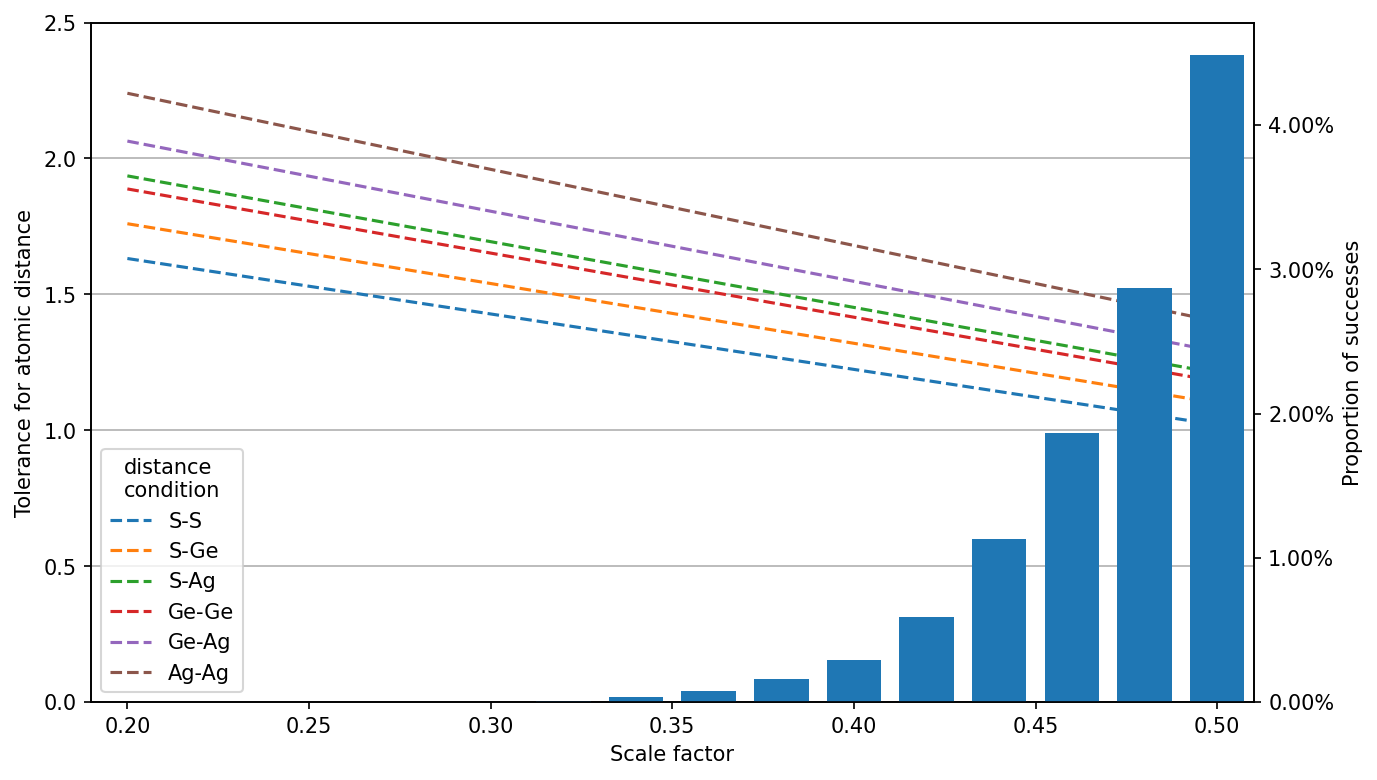

In [11]:
f, ax_tolerance = plt.subplots(figsize=(10, 6), dpi=150)

results.plot.line(x='scale', y=['S-S', 'S-Ge', 'S-Ag', 'Ge-Ge', 'Ge-Ag', 'Ag-Ag'], linestyle='dashed', ax=ax_tolerance)
ax_tolerance.set_ylim(0, 2.5)
ax_tolerance.set_ylabel('Tolerance for atomic distance')
ax_tolerance.set_xlabel('Scale factor')
ax_tolerance.legend(loc='lower left', title='distance\ncondition')
ax_tolerance.grid(axis='y')
ax_tolerance.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax_size= ax_tolerance.twinx()
ax_size.bar(results.scale, results.proportion, 0.015)
ax_size.yaxis.set_major_formatter(PercentFormatter(1))
ax_size.set_ylabel('Proportion of successes')
ax_size.set_xlim(0.19, 0.51)

# f.savefig('Ag32Ge4S24_generation_analysis.png', bbox_inches='tight', dpi=300)

From the result of `distance_scale_factor` dependency. Set the `distance_scale_factor` to `0.45` seems to be a good choice.

Finally, let's generate some structures and calculate their dissimilarity with most stable structure.

In [19]:
ground_truth = Structure.from_file('cifs/mp-9770.cif')

In [17]:
%%time

expect_size = 1_000_000
cfg = {'Ag': ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'],
 'Ge': ['a'],
 'S': ['a', 'a', 'a', 'a', 'a', 'a']
}
results = []
ret = cg.gen_many(expect_size, cfg, distance_scale_factor=0.45)
len(ret)

CPU times: user 4min 31s, sys: 1.02 s, total: 4min 32s
Wall time: 9.18 s


13953

In [18]:
structures = Parallel(n_jobs=20, verbose=1)(delayed(build_structure)(s) for s in ret)
structures = pd.DataFrame(structures)
structures.to_pickle('fully_random_generated_structures.pd.xz')

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    6.7s
[Parallel(n_jobs=20)]: Done 180 tasks      | elapsed:    7.6s
[Parallel(n_jobs=20)]: Done 680 tasks      | elapsed:    9.7s
[Parallel(n_jobs=20)]: Done 1380 tasks      | elapsed:   12.4s
[Parallel(n_jobs=20)]: Done 2280 tasks      | elapsed:   16.0s
[Parallel(n_jobs=20)]: Done 3380 tasks      | elapsed:   20.4s
[Parallel(n_jobs=20)]: Done 4680 tasks      | elapsed:   25.5s
[Parallel(n_jobs=20)]: Done 6180 tasks      | elapsed:   31.4s
[Parallel(n_jobs=20)]: Done 7880 tasks      | elapsed:   38.4s
[Parallel(n_jobs=20)]: Done 9780 tasks      | elapsed:   46.2s
[Parallel(n_jobs=20)]: Done 11880 tasks      | elapsed:   54.6s
[Parallel(n_jobs=20)]: Done 13914 out of 13953 | elapsed:  1.0min remaining:    0.2s
[Parallel(n_jobs=20)]: Done 13953 out of 13953 | elapsed:  1.0min finished


In [20]:
dissimilarity = structure_dissimilarity(ground_truth, structures.structure.tolist(), verbose=1, n_jobs=20)
structures = structures.assign(dissimilarity=dissimilarity)
structures.to_pickle('fully_random_generated_structures.pd.xz')

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   14.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  2.0min
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  4.9min
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  9.0min
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed: 14.2min
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed: 20.6min
[Parallel(n_jobs=20)]: Done 2410 tasks      | elapsed: 28.2min
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed: 37.0min
[Parallel(n_jobs=20)]: Done 4010 tasks      | elapsed: 46.9min
[Parallel(n_jobs=20)]: Done 4960 tasks      | elapsed: 58.0min
[Parallel(n_jobs=20)]: Done 6010 tasks      | elapsed: 70.3min
[Parallel(n_jobs=20)]: Done 7160 tasks      | elapsed: 83.8min
[Parallel(n_jobs=20)]: Done 8410 tasks      | elapsed: 98.4min
[Parallel(n_jobs=20)]: Done 9760 tasks      | elapsed: 114.1min
[Parallel(n_jobs=20)]: Done 11210 tasks     

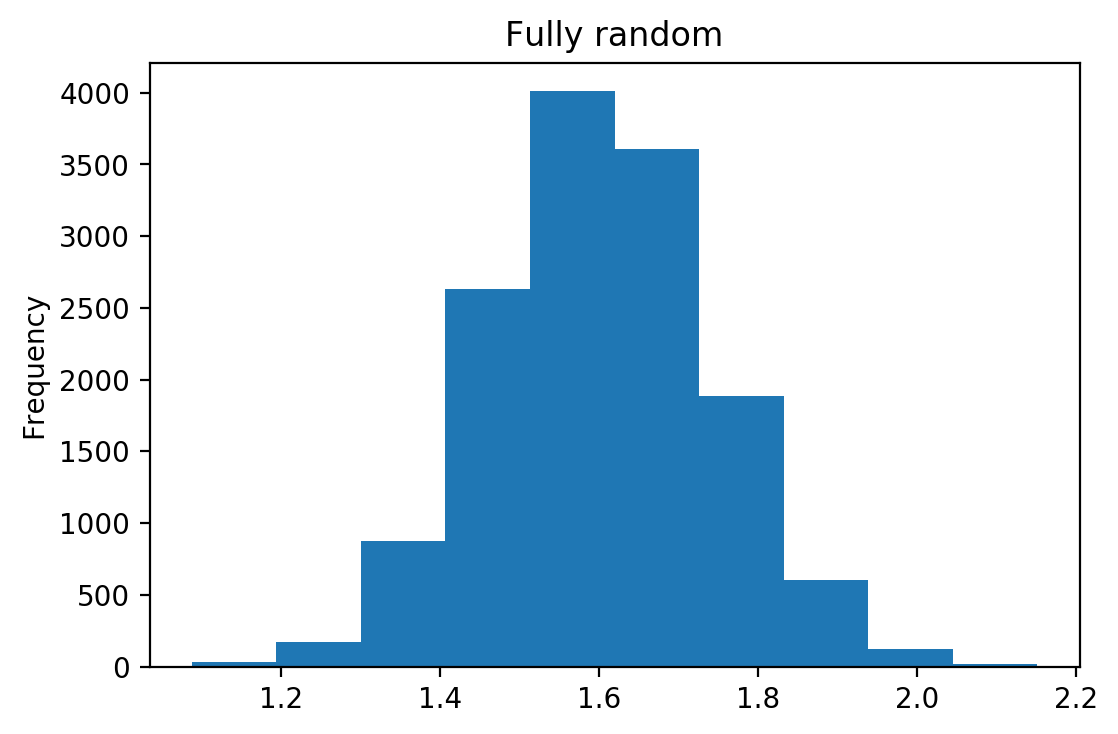

In [38]:
f, ax = plt.subplots(dpi=200)
structures = pd.read_pickle('fully_random_generated_structures.pd.xz')
structures.dissimilarity.plot.hist(ax=ax, title='Fully random')

## Generation using empirical atomic coordinates

### loose pattern

In [12]:
ag32ge4s24_like = pd.read_pickle('Ag32Ge4S24_like.pd.xz')
ag32ge4s24_like

,full_formula,composition,composition_ratio,total_atoms,elements,n_elements,space_group_num,space_group,wy_cfg,wy_reformat,wy_pattern,wy_pattern_loose,wy_unique,ss_cfg,ss_reformat,ss_pattern,ss_pattern_loose,ss_unique,volume_of_cell
id,,,,,,,,,,,,,,,,,,,
mp-9770,Ag32Ge4S24,"{'Ag': 32.0, 'Ge': 4.0, 'S': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Ag, Ge, S)",3,33,Pna2_1,"{'Ag': {'a': 32}, 'Ge': {'a': 4}, 'S': {'a': 24}}","{'Ag': ('a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Ag': {'1': 32}, 'Ge': {'1': 4}, 'S': {'1': 24}}","{'Ag': ('1',), 'Ge': ('1',), 'S': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",1254.599304
mp-15645,Ag32Sn4S24,"{'Ag': 32.0, 'Sn': 4.0, 'S': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Ag, S, Sn)",3,33,Pna2_1,"{'Ag': {'a': 32}, 'Sn': {'a': 4}, 'S': {'a': 24}}","{'Ag': ('a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Ag': {'1': 32}, 'Sn': {'1': 4}, 'S': {'1': 24}}","{'Ag': ('1',), 'Sn': ('1',), 'S': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",1299.334213
mp-557833,Ti4Ag32S24,"{'Ti': 4.0, 'Ag': 32.0, 'S': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Ag, S, Ti)",3,33,Pna2_1,"{'Ti': {'a': 4}, 'Ag': {'a': 32}, 'S': {'a': 24}}","{'Ti': ('a',), 'Ag': ('a', 'a', 'a', 'a', 'a',...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Ti': {'1': 4}, 'Ag': {'1': 32}, 'S': {'1': 24}}","{'Ti': ('1',), 'Ag': ('1',), 'S': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",1248.105025
mp-7614,Si4Ag32S24,"{'Si': 4.0, 'Ag': 32.0, 'S': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Ag, S, Si)",3,33,Pna2_1,"{'Si': {'a': 4}, 'Ag': {'a': 32}, 'S': {'a': 24}}","{'Si': ('a',), 'Ag': ('a', 'a', 'a', 'a', 'a',...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Si': {'1': 4}, 'Ag': {'1': 32}, 'S': {'1': 24}}","{'Si': ('1',), 'Ag': ('1',), 'S': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",1234.390114
mp-766575,Li32Ti4S24,"{'Li': 32.0, 'Ti': 4.0, 'S': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Li, S, Ti)",3,33,Pna2_1,"{'Li': {'a': 32}, 'Ti': {'a': 4}, 'S': {'a': 24}}","{'Li': ('a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Li': {'1': 32}, 'Ti': {'1': 4}, 'S': {'1': 24}}","{'Li': ('1',), 'Ti': ('1',), 'S': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",1070.938563
mp-761219,Na32Ti4O24,"{'Na': 32.0, 'Ti': 4.0, 'O': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Na, O, Ti)",3,33,Pna2_1,"{'Na': {'a': 32}, 'Ti': {'a': 4}, 'O': {'a': 24}}","{'Na': ('a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Na': {'1': 32}, 'Ti': {'1': 4}, 'O': {'1': 24}}","{'Na': ('1',), 'Ti': ('1',), 'O': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",886.582907


There are five compounds has composition `(4:24:32)` in materials project database. We can use their coordinates as an empirical distribution to help our structure generation. 
First, let's load all these structures.

In [13]:
ss = [Structure.from_file(f'cifs/{idx}.cif') for idx in ag32ge4s24_like.index[1:]]

Before going to the next step, I'd like to explain how to use exist coordinates as empirical coordinate distribution.
The most straight forward idea is assigning these coordinates to the generated structures by their Wyckoff position letters. Because Wyckoff position in the international table is written as a set of formulas which are something like this

```
(x,y,1/2)	(-y,x-y,1/2)	(-x+y,-x,1/2)	(-x,-y,1/2)
(y,-x+y,1/2)	(x-y,x,1/2)	(y,x,1/2)	(x-y,-y,1/2)
(-x,-x+y,1/2)	(-y,-x,1/2)	(-x+y,y,1/2)	(x,x-y,1/2)
```

So reuse a real coordinate can roughly be separated into the following steps.

1. calculate the equivalent coordinates for each site and get their Wyckoff position letter.
2. convert the fraction coordinates `(x, y, z)` into Wyckoff position coordinate `(x', y', z')`.
3. use converted coordinate to fulfill a structure.

We have prepared tool functions `get_equivalent_coords` and `WyckoffPositionConverter` for you to solve 1) and 2). For 3), this is exactly what the meaning of the parameter `empirical_coords` in `CrystalGenerator`.

In [14]:
get_equivalent_coords?

Signature:
get_equivalent_coords(
    structure: pymatgen.core.structure.Structure,
    *,
    mapper: Callable[[str, str, int], str] = None,
)
Docstring:
Extract the equivalent coordinates from the given structure.

Parameters
----------
structure:
    A pymatgen structure object.
mapper:
    Specify how to replace the elements. optional.
    ``mapper`` has signature ``[element, wyckoff_letter, multiplicity] -> target_element``
    If this parameter is given, will map the element in the structure to the corresponding one.
    For example, replace the `Ca` in `CaCO2` with `Mg`.

Returns
-------
DataFrame
    A dataframe contains all equivalent coordinates and their Wyckoff position letters.
File:      /usr/local/Caskroom/miniconda/base/envs/crystallus/lib/python3.7/site-packages/crystallus/utils.py
Type:      function


In [15]:
equivalent_coords = get_equivalent_coords(ss[0])
equivalent_coords

,element,spacegroup_num,multiplicity,wyckoff_letter,coordinate
0,Ag,33,4,a,"[0.020487, 0.019861, 0.612542]"
1,Ag,33,4,a,"[0.060832, 0.234882, 0.832489]"
2,Ag,33,4,a,"[0.06488, 0.566353, 0.518]"
3,Ag,33,4,a,"[0.09041, 0.603787, 0.193455]"
4,Ag,33,4,a,"[0.128856, 0.271558, 0.373184]"
5,Ag,33,4,a,"[0.226636, 0.876531, 0.190002]"
6,Ag,33,4,a,"[0.227452, 0.009636, 0.598612]"
7,Ag,33,4,a,"[0.239662, 0.638054, 0.413898]"
8,Sn,33,4,a,"[0.124966, 0.73461, 0.848657]"
9,S,33,4,a,"[0.000984, 0.268218, 0.217849]"


convert to Wyckoff position format

In [16]:
spg_num = equivalent_coords.spacegroup_num[0]
converter = WyckoffPositionConverter(spg_num)
converter?

Signature:  
converter(
    wyckoff_letters: Union[str, pandas.core.series.Series, List[str]],
    coords: Union[str, pandas.core.series.Series, List[Tuple[float, float, float]]],
    elements: Union[str, pandas.core.series.Series, List[str], NoneType] = None,
    *,
    data: pandas.core.frame.DataFrame = None,
)
Type:        WyckoffPositionConverter
String form: <crystallus.utils.WyckoffPositionConverter object at 0x7fcb32a63d10>
File:        /usr/local/Caskroom/miniconda/base/envs/crystallus/lib/python3.7/site-packages/crystallus/utils.py
Docstring:   Convert fraction coordinates into Wyckoff position formate. 


In [17]:
xyzs = converter('wyckoff_letter', 'coordinate', data=equivalent_coords)
xyzs

[('a', [0.020487, 0.019861, 0.612542]),
 ('a', [0.060832, 0.234882, 0.832489]),
 ('a', [0.06488, 0.566353, 0.518]),
 ('a', [0.09041, 0.603787, 0.193455]),
 ('a', [0.128856, 0.271558, 0.373184]),
 ('a', [0.226636, 0.876531, 0.190002]),
 ('a', [0.227452, 0.009636, 0.598612]),
 ('a', [0.239662, 0.638054, 0.413898]),
 ('a', [0.124966, 0.73461, 0.848657]),
 ('a', [0.000984, 0.268218, 0.217849]),
 ('a', [0.111732, 0.809143, 0.36478]),
 ('a', [0.120695, 0.483724, 0.98208]),
 ('a', [0.124876, 0.268389, 0.605612]),
 ('a', [0.126753, 0.989808, 0.979462]),
 ('a', [0.249023, 0.224527, 0.219278])]

Apply 1) and 2) for all these five structures. 

In [18]:
equivalent_coords =  pd.concat([get_equivalent_coords(s) for s in ss])
xyzs = converter('wyckoff_letter', 'coordinate', data=equivalent_coords)
len(xyzs)

75

Give these coordinates to the generator, and set `empirical_coords_variance` to give each coordinate a perturbation.
`empirical_coords_variance` has default value 0.01, and will be used to build normal distribution $N(0, \textrm{empirical_coords_variance})$ 

In [19]:
cg = CrystalGenerator(
    spacegroup_num=spg_num,
    volume_of_cell=1254.599172,
    variance_of_volume=10,
    empirical_coords=xyzs,
    empirical_coords_variance=0.02,
    verbose=False
)
cg

CrystalGenerator(            
    spacegroup_num=33,            
    volume_of_cell=1254.599172,            
    variance_of_volume=10,            
    angle_range=(30.0, 150.0),            
    angle_tolerance=20.0,            
    max_attempts_number=5000,            
    lattice=None,            
    empirical_coords=...,            
    empirical_coords_variance=0.02,            
    empirical_coords_sampling_rate=1.0,            
    empirical_coords_loose_sampling=True,            
    verbose=False            
    n_jobs=-1            
)

generation

In [20]:
%%time

expect_size = 1_000_000
cfg = {'Ag': ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'],
 'Ge': ['a'],
 'S': ['a', 'a', 'a', 'a', 'a', 'a']
}
results = []
ret = cg.gen_many(expect_size, cfg, distance_scale_factor=0.45)
len(ret)

CPU times: user 5min 28s, sys: 2.03 s, total: 5min 30s
Wall time: 31.5 s


3117

In [21]:
%%time

expect_size = 50_000
results = []
radius = {"S": 1.02, "Ge": 1.18, "Ag": 1.4}
raw = np.array(
    [0.0, 0, 2.04, 2.20, 2.42, 2.36, 2.58, 2.8]
)

for d in np.linspace(0.2, 0.5, 16):
    ret = cg.gen_many(expect_size, cfgs[0], distance_scale_factor=d)
    ratio = len(ret) / expect_size
    raw_ = raw * (1 - d)
    raw_[0], raw_[1] = d, ratio
    results.append(raw_)

CPU times: user 4min 14s, sys: 1.51 s, total: 4min 15s
Wall time: 24 s


<AxesSubplot:xlabel='scale'>

(0.0, 2.5)

Text(0, 0.5, 'Tolerance for atomic distance')

Text(0.5, 0, 'Scale factor')

<BarContainer object of 16 artists>

Text(0, 0.5, 'Proportion of successes')

(0.19, 0.51)

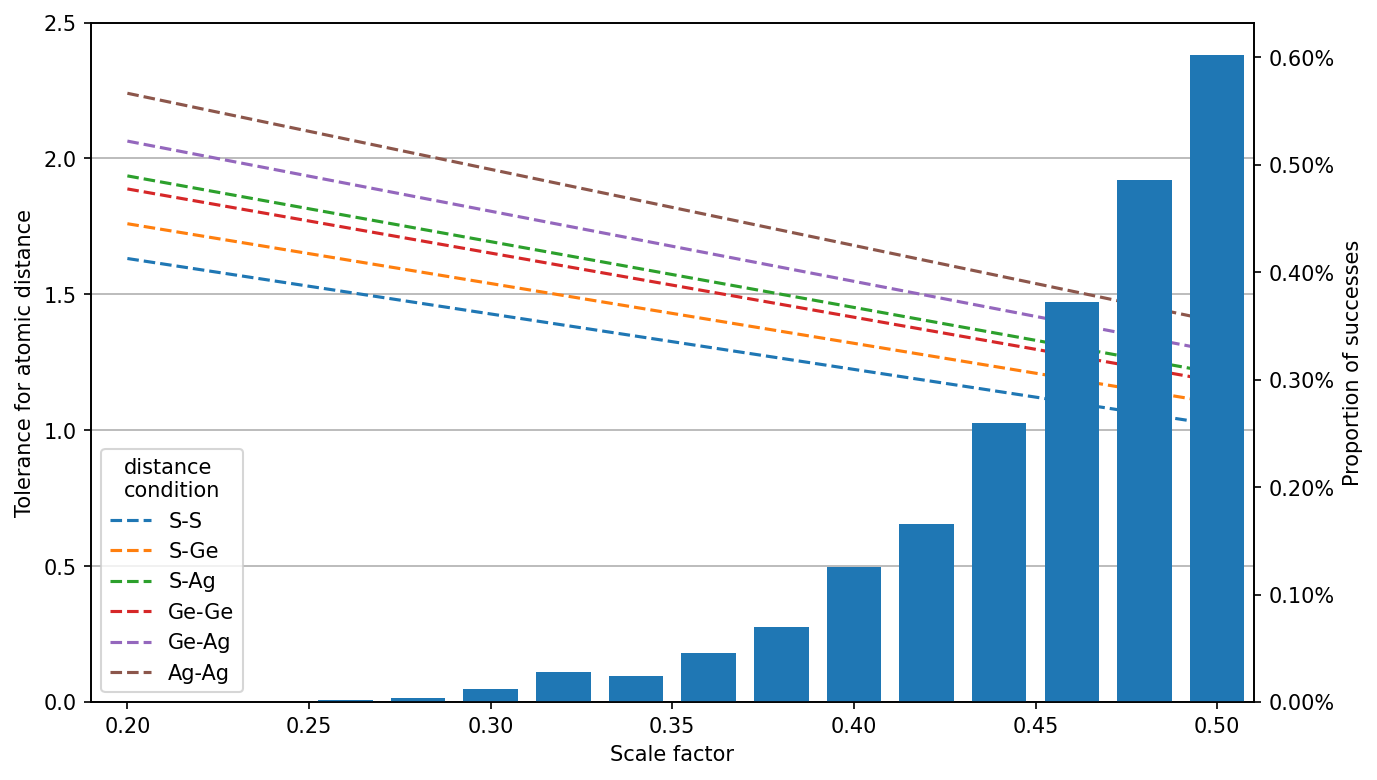

In [22]:
results = pd.DataFrame(results, columns=['scale', 'proportion', 'S-S', 'S-Ge', 'S-Ag', 'Ge-Ge', 'Ge-Ag', 'Ag-Ag'])
f, ax_tolerance = plt.subplots(figsize=(10, 6), dpi=150)

results.plot.line(x='scale', y=['S-S', 'S-Ge', 'S-Ag', 'Ge-Ge', 'Ge-Ag', 'Ag-Ag'], linestyle='dashed', ax=ax_tolerance)
ax_tolerance.set_ylim(0, 2.5)
ax_tolerance.set_ylabel('Tolerance for atomic distance')
ax_tolerance.set_xlabel('Scale factor')
ax_tolerance.legend(loc='lower left', title='distance\ncondition')
ax_tolerance.grid(axis='y')
ax_tolerance.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax_size= ax_tolerance.twinx()
ax_size.bar(results.scale, results.proportion, 0.015)
ax_size.yaxis.set_major_formatter(PercentFormatter(1))
ax_size.set_ylabel('Proportion of successes')
ax_size.set_xlim(0.19, 0.51)

# f.savefig('Ag32Ge4S24_generation_analysis.png', bbox_inches='tight', dpi=300)

In [33]:
%%time

expect_size = 1_000_000
cfg = {'Ag': ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'],
 'Ge': ['a'],
 'S': ['a', 'a', 'a', 'a', 'a', 'a']
}
results = []
ret = cg.gen_many(expect_size, cfg, distance_scale_factor=0.45)
len(ret)

CPU times: user 4min 50s, sys: 94.5 ms, total: 4min 50s
Wall time: 9.09 s


3111

In [34]:
structures = Parallel(n_jobs=20, verbose=1)(delayed(build_structure)(s) for s in ret)
structures = pd.DataFrame(structures)
structures.to_pickle('template_based_generated_structures.pd.xz')

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done 171 tasks      | elapsed:    7.1s
[Parallel(n_jobs=20)]: Done 1080 tasks      | elapsed:   10.8s
[Parallel(n_jobs=20)]: Done 2480 tasks      | elapsed:   16.0s
[Parallel(n_jobs=20)]: Done 3111 out of 3111 | elapsed:   18.2s finished


In [35]:
dissimilarity = structure_dissimilarity(ground_truth, structures.structure.tolist(), verbose=1, n_jobs=20)
structures = structures.assign(dissimilarity=dissimilarity)
structures.to_pickle('template_based_generated_structures.pd.xz')

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   13.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  2.0min
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  4.9min
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  9.0min
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed: 14.3min
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed: 20.7min
[Parallel(n_jobs=20)]: Done 2410 tasks      | elapsed: 28.3min
[Parallel(n_jobs=20)]: Done 3111 out of 3111 | elapsed: 36.5min finished


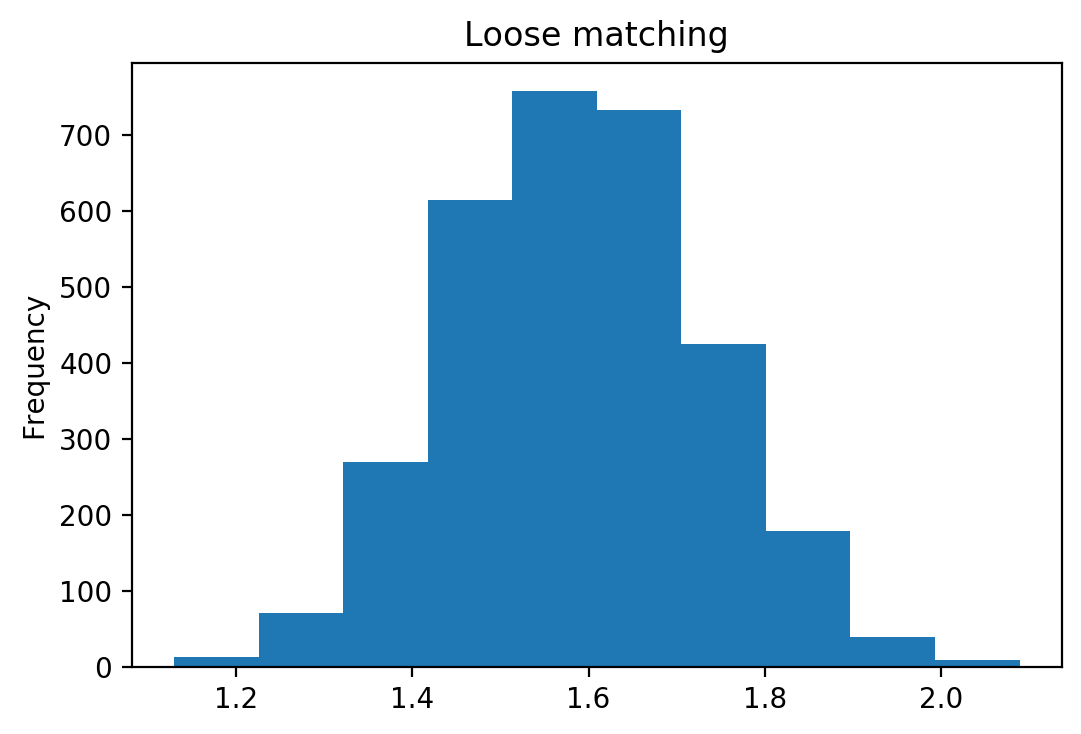

In [39]:
f, ax = plt.subplots(dpi=200)
structures = pd.read_pickle('template_based_generated_structures.pd.xz')
structures.dissimilarity.plot.hist(ax=ax, title='Loose matching')

### in strict pattern

In [23]:
ag32ge4s24_like

,full_formula,composition,composition_ratio,total_atoms,elements,n_elements,space_group_num,space_group,wy_cfg,wy_reformat,wy_pattern,wy_pattern_loose,wy_unique,ss_cfg,ss_reformat,ss_pattern,ss_pattern_loose,ss_unique,volume_of_cell
id,,,,,,,,,,,,,,,,,,,
mp-9770,Ag32Ge4S24,"{'Ag': 32.0, 'Ge': 4.0, 'S': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Ag, Ge, S)",3,33,Pna2_1,"{'Ag': {'a': 32}, 'Ge': {'a': 4}, 'S': {'a': 24}}","{'Ag': ('a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Ag': {'1': 32}, 'Ge': {'1': 4}, 'S': {'1': 24}}","{'Ag': ('1',), 'Ge': ('1',), 'S': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",1254.599304
mp-15645,Ag32Sn4S24,"{'Ag': 32.0, 'Sn': 4.0, 'S': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Ag, S, Sn)",3,33,Pna2_1,"{'Ag': {'a': 32}, 'Sn': {'a': 4}, 'S': {'a': 24}}","{'Ag': ('a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Ag': {'1': 32}, 'Sn': {'1': 4}, 'S': {'1': 24}}","{'Ag': ('1',), 'Sn': ('1',), 'S': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",1299.334213
mp-557833,Ti4Ag32S24,"{'Ti': 4.0, 'Ag': 32.0, 'S': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Ag, S, Ti)",3,33,Pna2_1,"{'Ti': {'a': 4}, 'Ag': {'a': 32}, 'S': {'a': 24}}","{'Ti': ('a',), 'Ag': ('a', 'a', 'a', 'a', 'a',...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Ti': {'1': 4}, 'Ag': {'1': 32}, 'S': {'1': 24}}","{'Ti': ('1',), 'Ag': ('1',), 'S': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",1248.105025
mp-7614,Si4Ag32S24,"{'Si': 4.0, 'Ag': 32.0, 'S': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Ag, S, Si)",3,33,Pna2_1,"{'Si': {'a': 4}, 'Ag': {'a': 32}, 'S': {'a': 24}}","{'Si': ('a',), 'Ag': ('a', 'a', 'a', 'a', 'a',...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Si': {'1': 4}, 'Ag': {'1': 32}, 'S': {'1': 24}}","{'Si': ('1',), 'Ag': ('1',), 'S': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",1234.390114
mp-766575,Li32Ti4S24,"{'Li': 32.0, 'Ti': 4.0, 'S': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Li, S, Ti)",3,33,Pna2_1,"{'Li': {'a': 32}, 'Ti': {'a': 4}, 'S': {'a': 24}}","{'Li': ('a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Li': {'1': 32}, 'Ti': {'1': 4}, 'S': {'1': 24}}","{'Li': ('1',), 'Ti': ('1',), 'S': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",1070.938563
mp-761219,Na32Ti4O24,"{'Na': 32.0, 'Ti': 4.0, 'O': 24.0}","(4.0, 24.0, 32.0)",60.0,"(Na, O, Ti)",3,33,Pna2_1,"{'Na': {'a': 32}, 'Ti': {'a': 4}, 'O': {'a': 24}}","{'Na': ('a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'...","((a,), (a, a, a, a, a, a), (a, a, a, a, a, a, ...","(a, a, a, a, a, a, a, a, a, a, a, a, a, a, a)","(a,)","{'Na': {'1': 32}, 'Ti': {'1': 4}, 'O': {'1': 24}}","{'Na': ('1',), 'Ti': ('1',), 'O': ('1',)}","((1,), (1,), (1,))","(1, 1, 1)","(1,)",886.582907


In [24]:
def mapper(elem, wy, mul):
    if elem in ['Ag', 'Li', 'Na']:
        return 'Ag'
    if elem in ['Ti', 'Si']:
        return 'Ge'
    return 'S'

In [25]:
equivalent_coords =  pd.concat([get_equivalent_coords(s, mapper=mapper) for s in ss])
xyzs = converter('wyckoff_letter', 'coordinate', 'target_element', data=equivalent_coords)
len(xyzs)

75

In [27]:
cg = CrystalGenerator(
    spacegroup_num=spg_num,
    volume_of_cell=1254.599172,
    variance_of_volume=10,
    empirical_coords=xyzs,
    empirical_coords_variance=0.02,
    empirical_coords_loose_sampling=False,
    verbose=False
)
cg

CrystalGenerator(            
    spacegroup_num=33,            
    volume_of_cell=1254.599172,            
    variance_of_volume=10,            
    angle_range=(30.0, 150.0),            
    angle_tolerance=20.0,            
    max_attempts_number=5000,            
    lattice=None,            
    empirical_coords=...,            
    empirical_coords_variance=0.02,            
    empirical_coords_sampling_rate=1.0,            
    empirical_coords_loose_sampling=False,            
    verbose=False            
    n_jobs=-1            
)

generation

In [28]:
%%time

expect_size = 50_000
results = []
radius = {"S": 1.02, "Ge": 1.18, "Ag": 1.4}
raw = np.array(
    [0.0, 0, 2.04, 2.20, 2.42, 2.36, 2.58, 2.8]
)

for d in np.linspace(0.2, 0.5, 16):
    ret = cg.gen_many(expect_size, cfgs[0], distance_scale_factor=d)
    ratio = len(ret) / expect_size
    raw_ = raw * (1 - d)
    raw_[0], raw_[1] = d, ratio
    results.append(raw_)

CPU times: user 4min 34s, sys: 1.88 s, total: 4min 36s
Wall time: 27.4 s


<AxesSubplot:xlabel='scale'>

(0.0, 2.5)

Text(0, 0.5, 'Tolerance for atomic distance')

Text(0.5, 0, 'Scale factor')

<BarContainer object of 16 artists>

Text(0, 0.5, 'Proportion of successes')

(0.19, 0.51)

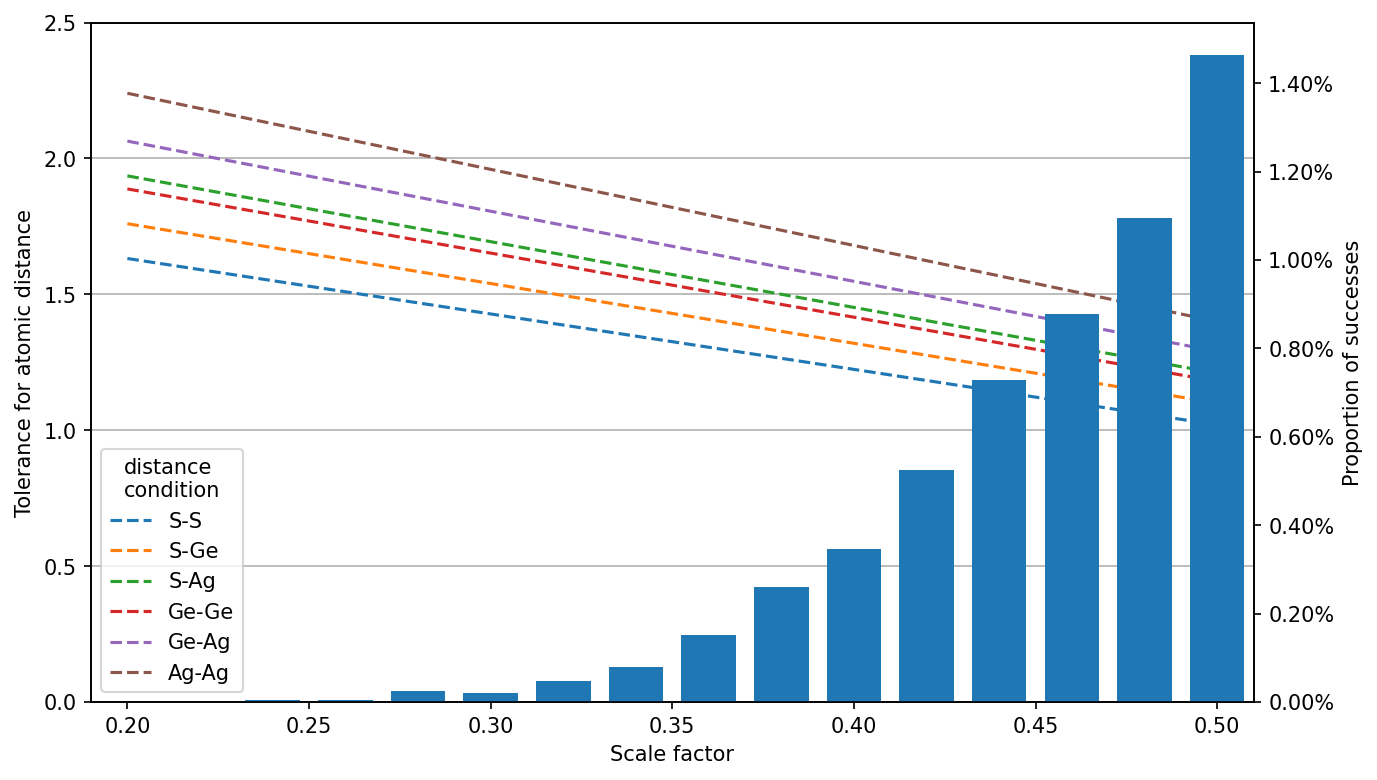

In [29]:
results = pd.DataFrame(results, columns=['scale', 'proportion', 'S-S', 'S-Ge', 'S-Ag', 'Ge-Ge', 'Ge-Ag', 'Ag-Ag'])
f, ax_tolerance = plt.subplots(figsize=(10, 6), dpi=150)

results.plot.line(x='scale', y=['S-S', 'S-Ge', 'S-Ag', 'Ge-Ge', 'Ge-Ag', 'Ag-Ag'], linestyle='dashed', ax=ax_tolerance)
ax_tolerance.set_ylim(0, 2.5)
ax_tolerance.set_ylabel('Tolerance for atomic distance')
ax_tolerance.set_xlabel('Scale factor')
ax_tolerance.legend(loc='lower left', title='distance\ncondition')
ax_tolerance.grid(axis='y')
ax_tolerance.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax_size= ax_tolerance.twinx()
ax_size.bar(results.scale, results.proportion, 0.015)
ax_size.yaxis.set_major_formatter(PercentFormatter(1))
ax_size.set_ylabel('Proportion of successes')
ax_size.set_xlim(0.19, 0.51)

# f.savefig('Ag32Ge4S24_generation_analysis.png', bbox_inches='tight', dpi=300)

In [26]:
%%time

expect_size = 1_000_000
cfg = {'Ag': ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'],
 'Ge': ['a'],
 'S': ['a', 'a', 'a', 'a', 'a', 'a']
}
results = []
ret = cg.gen_many(expect_size, cfg, distance_scale_factor=0.45)
len(ret)

CPU times: user 4min 47s, sys: 244 ms, total: 4min 47s
Wall time: 7.61 s


6362

In [27]:
structures = Parallel(n_jobs=20, verbose=1)(delayed(build_structure)(s) for s in ret)
structures = pd.DataFrame(structures)
structures.to_pickle('strict_generated_structures.pd.xz')

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    5.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    8.0s
[Parallel(n_jobs=20)]: Done 1100 tasks      | elapsed:   11.1s
[Parallel(n_jobs=20)]: Done 2000 tasks      | elapsed:   15.3s
[Parallel(n_jobs=20)]: Done 3100 tasks      | elapsed:   20.3s
[Parallel(n_jobs=20)]: Done 4400 tasks      | elapsed:   27.3s
[Parallel(n_jobs=20)]: Done 5900 tasks      | elapsed:   34.2s
[Parallel(n_jobs=20)]: Done 6362 out of 6362 | elapsed:   36.2s finished


In [28]:
dissimilarity = structure_dissimilarity(ground_truth, structures.structure.tolist(), verbose=1, n_jobs=20)
structures = structures.assign(dissimilarity=dissimilarity)
structures.to_pickle('strict_generated_structures.pd.xz')

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   11.8s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  4.1min
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  7.5min
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed: 11.9min
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed: 17.2min
[Parallel(n_jobs=20)]: Done 2410 tasks      | elapsed: 23.6min
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed: 30.8min
[Parallel(n_jobs=20)]: Done 4010 tasks      | elapsed: 39.1min
[Parallel(n_jobs=20)]: Done 4960 tasks      | elapsed: 48.4min
[Parallel(n_jobs=20)]: Done 6010 tasks      | elapsed: 58.6min
[Parallel(n_jobs=20)]: Done 6362 out of 6362 | elapsed: 62.0min finished


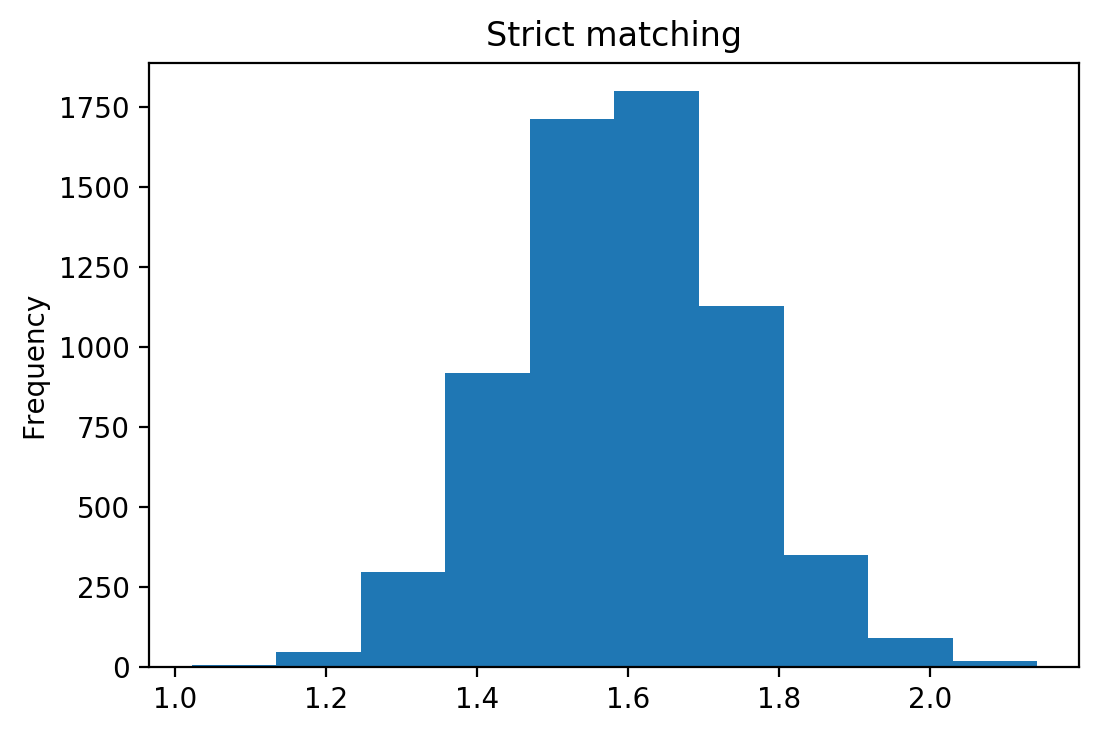

In [37]:
f, ax = plt.subplots(dpi=200)
structures = pd.read_pickle('strict_generated_structures.pd.xz')
structures.dissimilarity.plot.hist(ax=ax, title='Strict matching')

### sampling from groundtruth coords

In [30]:
equivalent_coords = get_equivalent_coords(ground_truth)

In [31]:
spg_num = equivalent_coords.spacegroup_num[0]
converter = WyckoffPositionConverter(spg_num)
xyzs = converter('wyckoff_letter', 'coordinate', data=equivalent_coords)
len(xyzs)

15

In [32]:
# loose pattern

cg = CrystalGenerator(
    spacegroup_num=spg_num,
    volume_of_cell=1254.599172,
    variance_of_volume=10,
    empirical_coords=xyzs,
    empirical_coords_variance=0.,
    empirical_coords_loose_sampling=True,
    verbose=False
)
cg

CrystalGenerator(            
    spacegroup_num=33,            
    volume_of_cell=1254.599172,            
    variance_of_volume=10,            
    angle_range=(30.0, 150.0),            
    angle_tolerance=20.0,            
    max_attempts_number=5000,            
    lattice=None,            
    empirical_coords=...,            
    empirical_coords_variance=0.0,            
    empirical_coords_sampling_rate=1.0,            
    empirical_coords_loose_sampling=True,            
    verbose=False            
    n_jobs=-1            
)

In [33]:
%%time

expect_size = 50_000
results = []
radius = {"S": 1.02, "Ge": 1.18, "Ag": 1.4}
raw = np.array(
    [0.0, 0, 2.04, 2.20, 2.42, 2.36, 2.58, 2.8]
)

for d in np.linspace(0.2, 0.5, 16):
    ret = cg.gen_many(expect_size, cfgs[0], distance_scale_factor=d)
    ratio = len(ret) / expect_size
    raw_ = raw * (1 - d)
    raw_[0], raw_[1] = d, ratio
    results.append(raw_)

CPU times: user 4min 11s, sys: 3.57 s, total: 4min 15s
Wall time: 56.6 s


<BarContainer object of 16 artists>

Text(0, 0.5, 'Proportion of successes')

(0.19, 0.51)

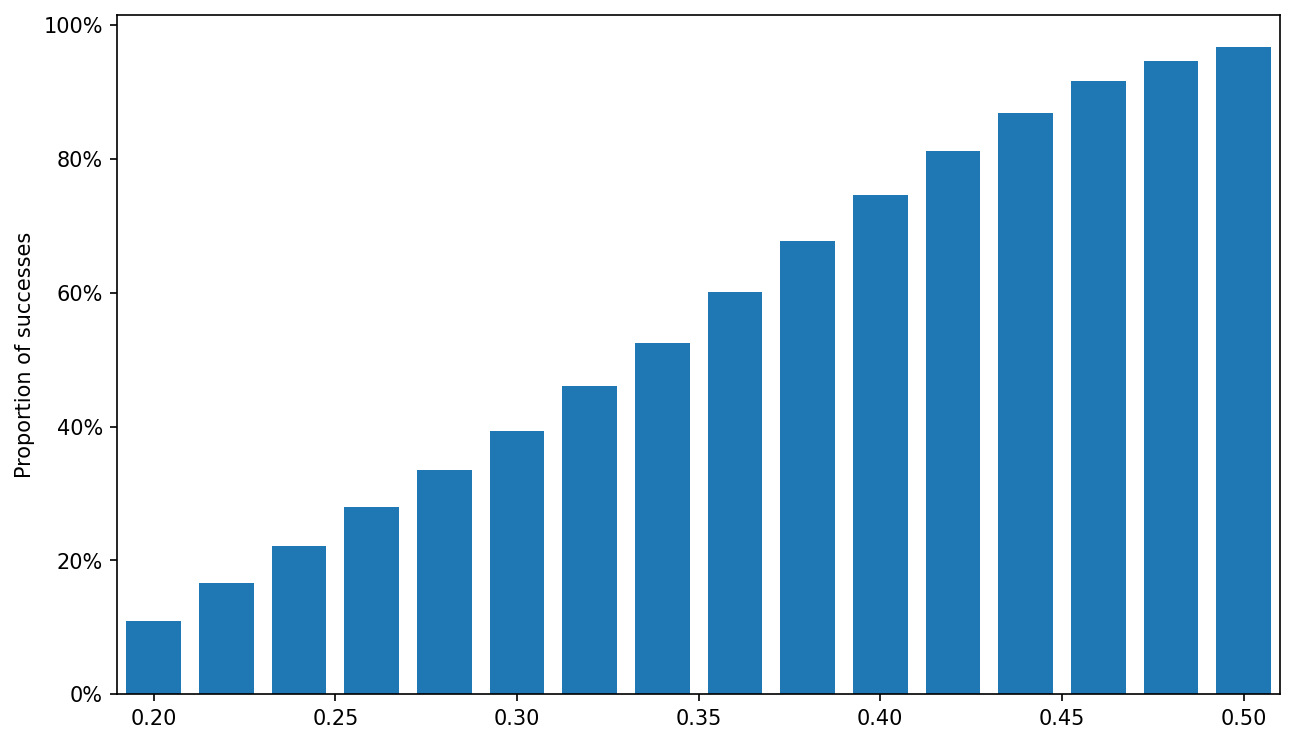

In [34]:
results = pd.DataFrame(results, columns=['scale', 'proportion', 'S-S', 'S-Ge', 'S-Ag', 'Ge-Ge', 'Ge-Ag', 'Ag-Ag'])
f, ax_tolerance = plt.subplots(figsize=(10, 6), dpi=150)

# results.plot.line(x='scale', y=['S-S', 'S-Ge', 'S-Ag', 'Ge-Ge', 'Ge-Ag', 'Ag-Ag'], linestyle='dashed', ax=ax_tolerance)
# ax_tolerance.set_ylim(0, 2.5)
# ax_tolerance.set_ylabel('Tolerance for atomic distance')
# ax_tolerance.set_xlabel('Scale factor')
# ax_tolerance.legend(loc='lower left', title='distance\ncondition')
# ax_tolerance.grid(axis='y')
# ax_tolerance.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# ax_size= ax_tolerance.twinx()
ax_size= ax_tolerance
ax_size.bar(results.scale, results.proportion, 0.015)
ax_size.yaxis.set_major_formatter(PercentFormatter(1))
ax_size.set_ylabel('Proportion of successes')
ax_size.set_xlim(0.19, 0.51)

# f.savefig('Ag32Ge4S24_generation_analysis.png', bbox_inches='tight', dpi=300)

In [63]:
%%time

expect_size = 10_000
cfg = {'Ag': ['a'] * 8,
 'Ge': ['a'],
 'S': ['a'] * 6
}
results = []
ret = cg.gen_many(expect_size, cfg, distance_scale_factor=0.45)
len(ret)

CPU times: user 9.13 s, sys: 517 ms, total: 9.64 s
Wall time: 5.14 s


8932

In [68]:
structures = Parallel(n_jobs=20, verbose=1)(delayed(build_structure)(s) for s in ret)
structures = pd.DataFrame(structures)
structures.to_pickle('real_coord_structures.pd.xz')

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   11.7s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   12.7s
[Parallel(n_jobs=20)]: Done 560 tasks      | elapsed:   14.5s
[Parallel(n_jobs=20)]: Done 1260 tasks      | elapsed:   17.7s
[Parallel(n_jobs=20)]: Done 2160 tasks      | elapsed:   21.8s
[Parallel(n_jobs=20)]: Done 3260 tasks      | elapsed:   26.8s
[Parallel(n_jobs=20)]: Done 4560 tasks      | elapsed:   32.8s
[Parallel(n_jobs=20)]: Done 6060 tasks      | elapsed:   39.7s
[Parallel(n_jobs=20)]: Done 7760 tasks      | elapsed:   47.4s
[Parallel(n_jobs=20)]: Done 8932 out of 8932 | elapsed:   52.7s finished


In [69]:
for idx, struct in structures.structure.items():
    true_coord = set([str(s) for s in ground_truth.frac_coords])
    if not set([str(s) for s in struct.frac_coords]) == true_coord:
        print(idx)

In [70]:
dissimilarity = structure_dissimilarity(ground_truth, structures.structure.tolist(), verbose=1, n_jobs=20)
structures = structures.assign(dissimilarity=dissimilarity)
structures.to_pickle('real_coord_structures.pd.xz')

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   12.3s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  4.2min
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  7.7min
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed: 12.2min
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed: 17.8min
[Parallel(n_jobs=20)]: Done 2410 tasks      | elapsed: 24.3min
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed: 31.8min
[Parallel(n_jobs=20)]: Done 4010 tasks      | elapsed: 40.3min
[Parallel(n_jobs=20)]: Done 4960 tasks      | elapsed: 49.9min
[Parallel(n_jobs=20)]: Done 6010 tasks      | elapsed: 60.4min
[Parallel(n_jobs=20)]: Done 7160 tasks      | elapsed: 72.0min
[Parallel(n_jobs=20)]: Done 8410 tasks      | elapsed: 84.5min
[Parallel(n_jobs=20)]: Done 8932 out of 8932 | elapsed: 89.8min finished


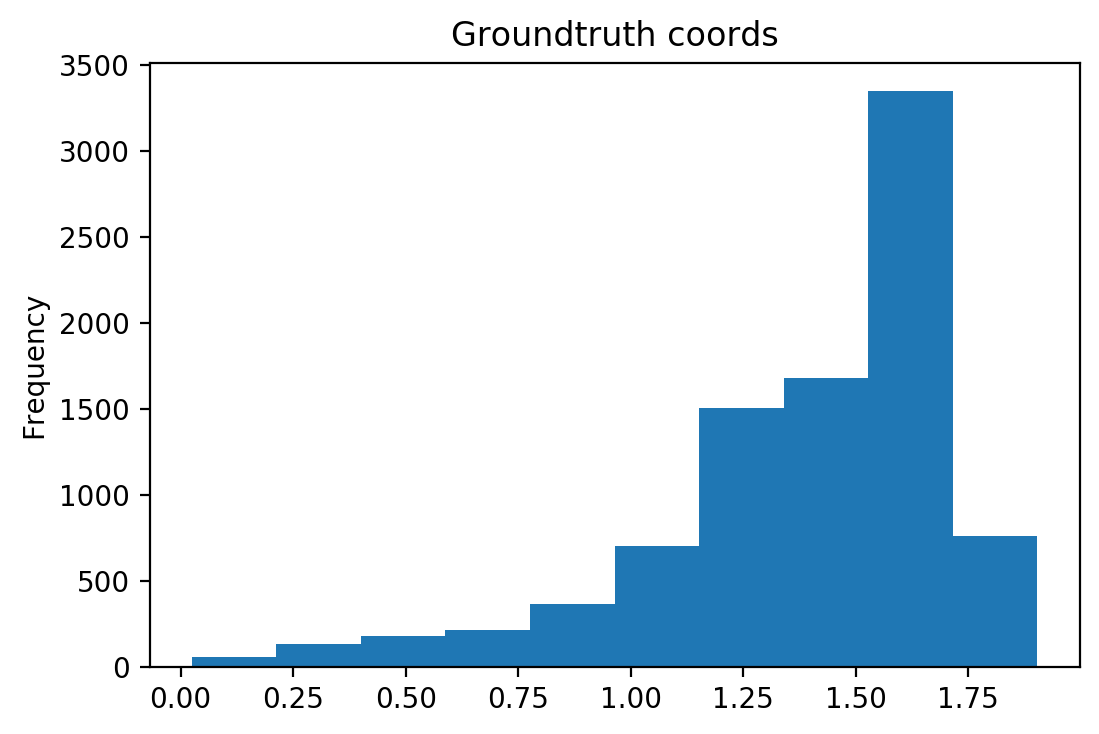

In [71]:
f, ax = plt.subplots(dpi=200)
structures = pd.read_pickle('real_coord_structures.pd.xz')
structures.dissimilarity.plot.hist(ax=ax, title='Groundtruth coords')

generation

In [84]:
dissimilarity = structure_dissimilarity(ground_truth, ss, verbose=1, n_jobs=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


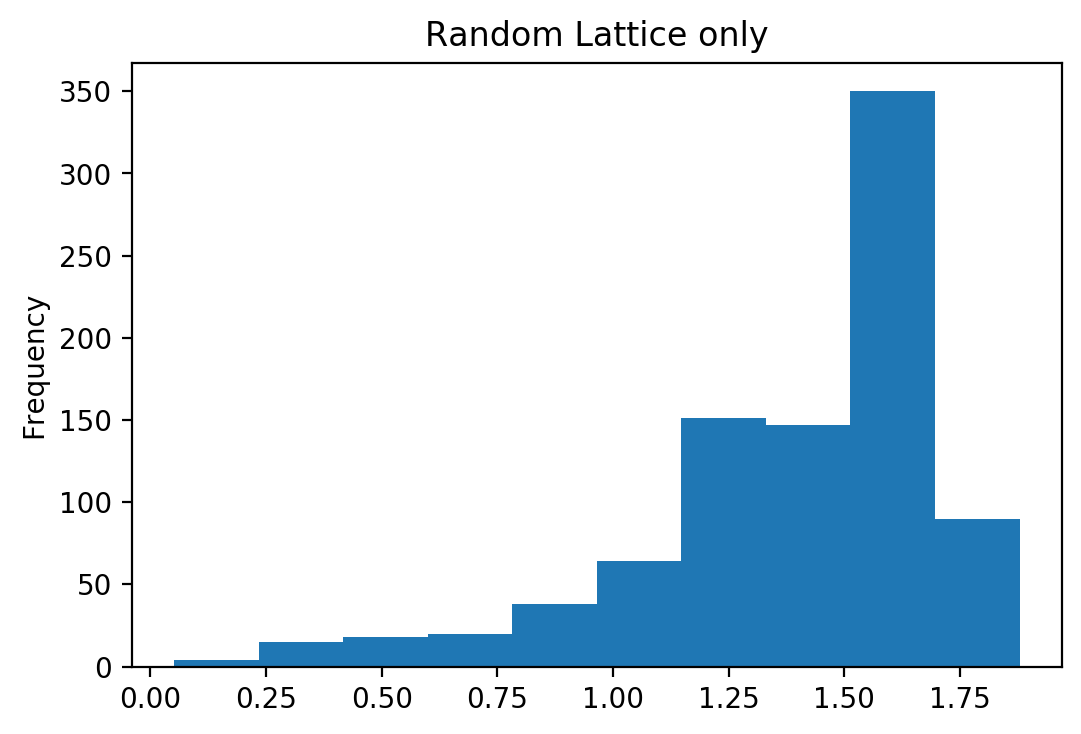

In [80]:
f, ax = plt.subplots(dpi=200)
# structures = pd.read_pickle('real_coord_structures.pd.xz')
structures.dissimilarity.plot.hist(ax=ax, title='Random Lattice only')